# April 14,15, 2022: Understanding stimulus of emoprox2 paradigm

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations
from operator import add

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *
from nb.apr22.ROIwise_appr_retr_timeseries_plots_helper import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-04-18 19:29:32.478890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-18 19:29:34.615596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-18 19:29:34.667649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-18 19:29:34.667883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-18 19:29:34.667922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## testing convolution 

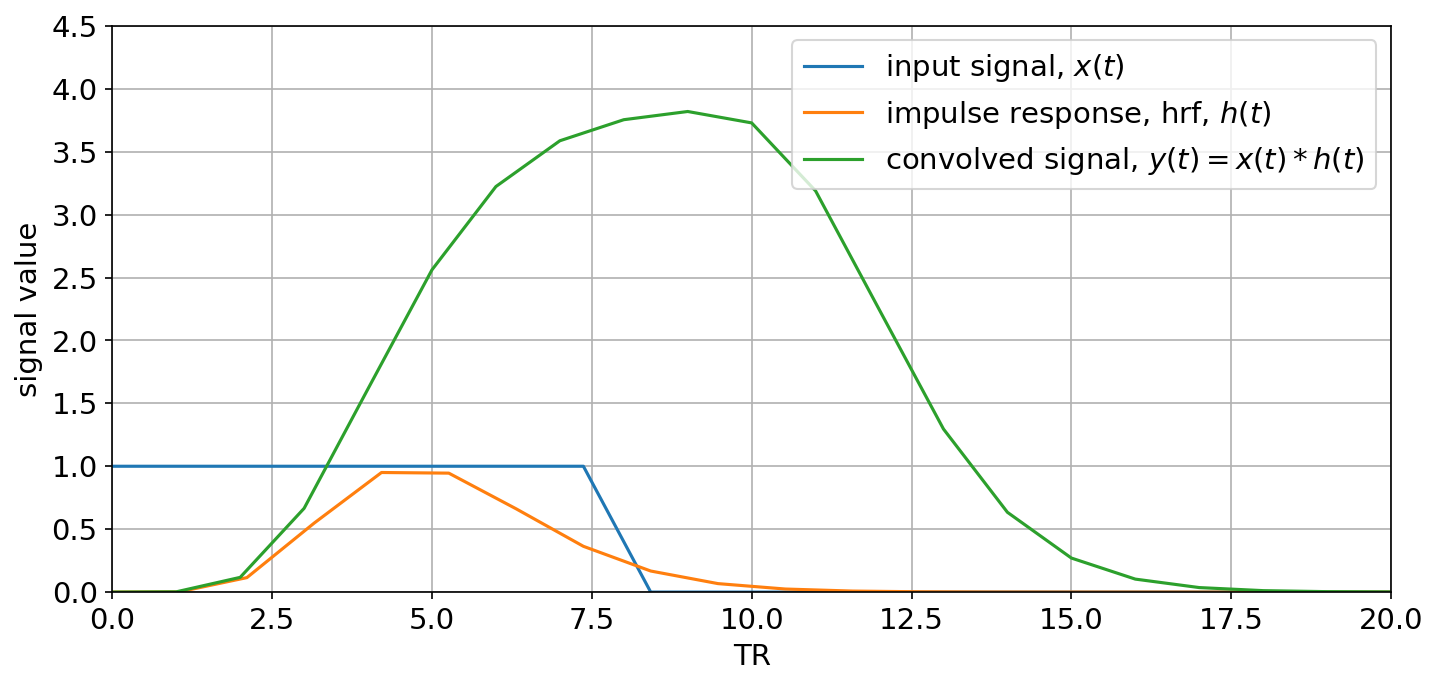

In [22]:
n = 20
t = np.linspace(0, n, num=n*1)

p, q = 8.6, 0.547
hrf = np.power((t/(p*q)), p) * np.exp(p-t/q)

x = np.zeros_like(t)
x[0:8*1] = 1.0

y = np.convolve(x, hrf, 'full')

nrows, ncols = 1, 1
figsize = (11*ncols, 5*nrows)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=figsize, 
    sharex=False, 
    sharey=False, 
    dpi=150)

ax = axs
ax.plot(t, x, label='input signal, $x(t)$')
ax.plot(t, hrf, label='impulse response, hrf, $h(t)$')
ax.plot(y, label='convolved signal, $y(t) = x(t) * h(t)$')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(0.0, 4.5)
ax.set_xlabel(f"TR")
ax.set_ylabel(f"signal value")
ax.grid(True)
ax.legend()

this convolution shows that for a constant stimulus ($x(t)$), hemodynamic signal (fMRI) will peak at around 8.75TRs. But the main bulk of the signal starts from 5TRs or 6TRs.

## canonical fMRI responses

In [3]:
%%bash
proj_path="/home/govindas/vscode-BSWIFT-mnt"
main_working_path="/home/govindas/explainable-ai"
out_path="${main_working_path}/nb/apr22"
subj='002'

# 3dDeconvolve -x1D_stop \
#  -polort A \
#  -nodata 2160 1.25 \
#  -num_stimts 1 \
#  -stim_times_AM1 1 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllApprMR.txt" "dmBLOCK(1)" -stim_label 1 closeAppr \
#  -x1D ${subj}_design_mat.xmat.1D

3dDeconvolve -overwrite \
 -x1D_stop \
 -input "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/ICA_AROMA/CON${subj}_EP_TR_MNI_2mm_SI_denoised.nii.gz" \
 -jobs 4 \
 -mask "${proj_path}/share/templates/MNI152_T1_2mm_brain_GM_02182017.nii.gz" \
 -polort A \
 -local_times \
 -concat "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/runConcatInfo.1D" \
 -censor "${proj_path}/eCON/dataset/preproc2/CON${subj}/regs_fancy/CON${subj}_censor15.txt" \
 -num_stimts 2 \
 -tout \
 -stim_times_AM1 1 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllApprMR.txt" "dmBLOCK(1)"     -stim_label 1 "closeAppr" \
 -stim_times_AM1 2 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllRetrMR.txt" "dmBLOCK(1)"     -stim_label 2 "closeRetr" \
 -ortvec "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/CON${subj}_MotionPar.txt"'[1..6]'  rawMotion \
 -ortvec "${proj_path}/eCON/dataset/preproc2/CON${subj}/regs_fancy/CON${subj}_MotionParDeriv.txt"  derMotion \
 -x1D "${out_path}/subj${subj}.xmat.1D" \
 -x1D_uncensored "${out_path}/subj${subj}_uncens.xmat.1D" \
#  -bucket /data/bswift-1/Pessoa_Lab/eCON/dataset/results_ShockCensored/CON002/controllable/splitted_regs/ApprRetr_deconv/CON002_appr_bucket.nii.gz

chmod +x "${main_working_path}/helpers/getVIF.py"
# echo "${out_path}/subj${subj}.xmat.1D" | "${main_working_path}/helpers/getVIF.py" 

++ '-stim_times_AM1 1 /home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllApprMR.txt' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllApprMR.txt'
++ '-stim_times_AM1 2 /home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllRetrMR.txt' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllRetrMR.txt'
++ No '-bucket' option given ==> using '-bucket Decon'
++ 3dDeconvolve extending num_stimts from 2 to 14 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
++ Authored by: B. Douglas

In [4]:
subj = '002'

# (canonical) fMRI response time series
fpath = f"{proj_dir}/nb/apr22/subj{subj}_uncens.xmat.1D"

rawCols = open(fpath, 'r').readlines()[3].split('"')[1].split(';')
rawCols = [i.strip() for i in rawCols]
# using only regressors of interest
# removing 40 polort regressors and 6 motion regressors
useCols = [i for i in rawCols if "Run" not in i if "Motion" not in i]
# print(len(useCols), useCols)

df = pd.DataFrame(np.loadtxt(fpath), columns=rawCols)
df.columns
X_variables = df[useCols]

num_blocks = 6 * 2 # 2 blocks within each run
l = len(X_variables) // (num_blocks) # window length of a block

appr_regs = [X_variables['closeAppr#0'].loc[l*idx_block:l*(idx_block+1)].values for idx_block in np.arange(num_blocks)]
retr_regs = [X_variables['closeRetr#0'].loc[l*idx_block:l*(idx_block+1)].values for idx_block in np.arange(num_blocks)]

## stimulus time series

In [5]:
# stimulus time series
proj_path = "/home/govindas/vscode-BSWIFT-mnt"
censor15_file = f"{proj_path}/eCON/dataset/preproc2/CON{subj}/regs_fancy/CON{subj}_censor15.txt"
censor15 = np.loadtxt(censor15_file)

tr = 1.25
TR_ref = np.arange(0,2*l*tr,tr)
def return_closest_TR(timings):
    """
    Parameter
    ---------
    timings: numpy.1darray of stim onsets
    
    Returns
    -------
    tuple of numpy.1darray,
        TR_time, TRs = TR times that closesly match with the stim onsets, TR number
    """
    TR_time = []; TRs = []
    for n in timings:
        time = min(TR_ref, key=lambda x:abs(x-n))
        TR_time.append(time)
        TRs.append(np.where(TR_ref==time)[0][0])
    return np.array(TR_time), np.array(TRs)

def get_stimulus_time_series(stim_file):
    with open(stim_file, 'r') as f:
        stim_list = f.read().split('\n')

    stimulus = np.zeros(shape=(len(df),))
    for idx_run, run in enumerate(stim_list):
        events = run.split(' ')
        # starts, durations
        starts_durs = [list(map(float, event.split(':'))) for event in events]
        starts_durs = np.stack(starts_durs, axis=0)
        starts_durs = np.apply_along_axis(return_closest_TR, axis=1, arr=starts_durs)[:, 1, :].astype(int)
        starts, durs = starts_durs[:, 0], starts_durs[:, 1]
        starts += idx_run * 2*l
        for start, dur in zip(starts, durs):
            stimulus[start:start+dur] = 1.0
    stimulus *= censor15
    return [stimulus[l*idx_block:l*(idx_block+1)] for idx_block in np.arange(num_blocks)]

appr_file = (f"{proj_path}/eCON/dataset/preproc2/CON{subj}" 
             f"/splitted_regs_fancy/CON{subj}_closeAllApprMR.txt")
retr_file = (f"{proj_path}/eCON/dataset/preproc2/CON{subj}"
             f"/splitted_regs_fancy/CON{subj}_closeAllRetrMR.txt")

appr_stims = get_stimulus_time_series(appr_file)
retr_stims = get_stimulus_time_series(retr_file)
    

## plots

### stimulus and fMRI response

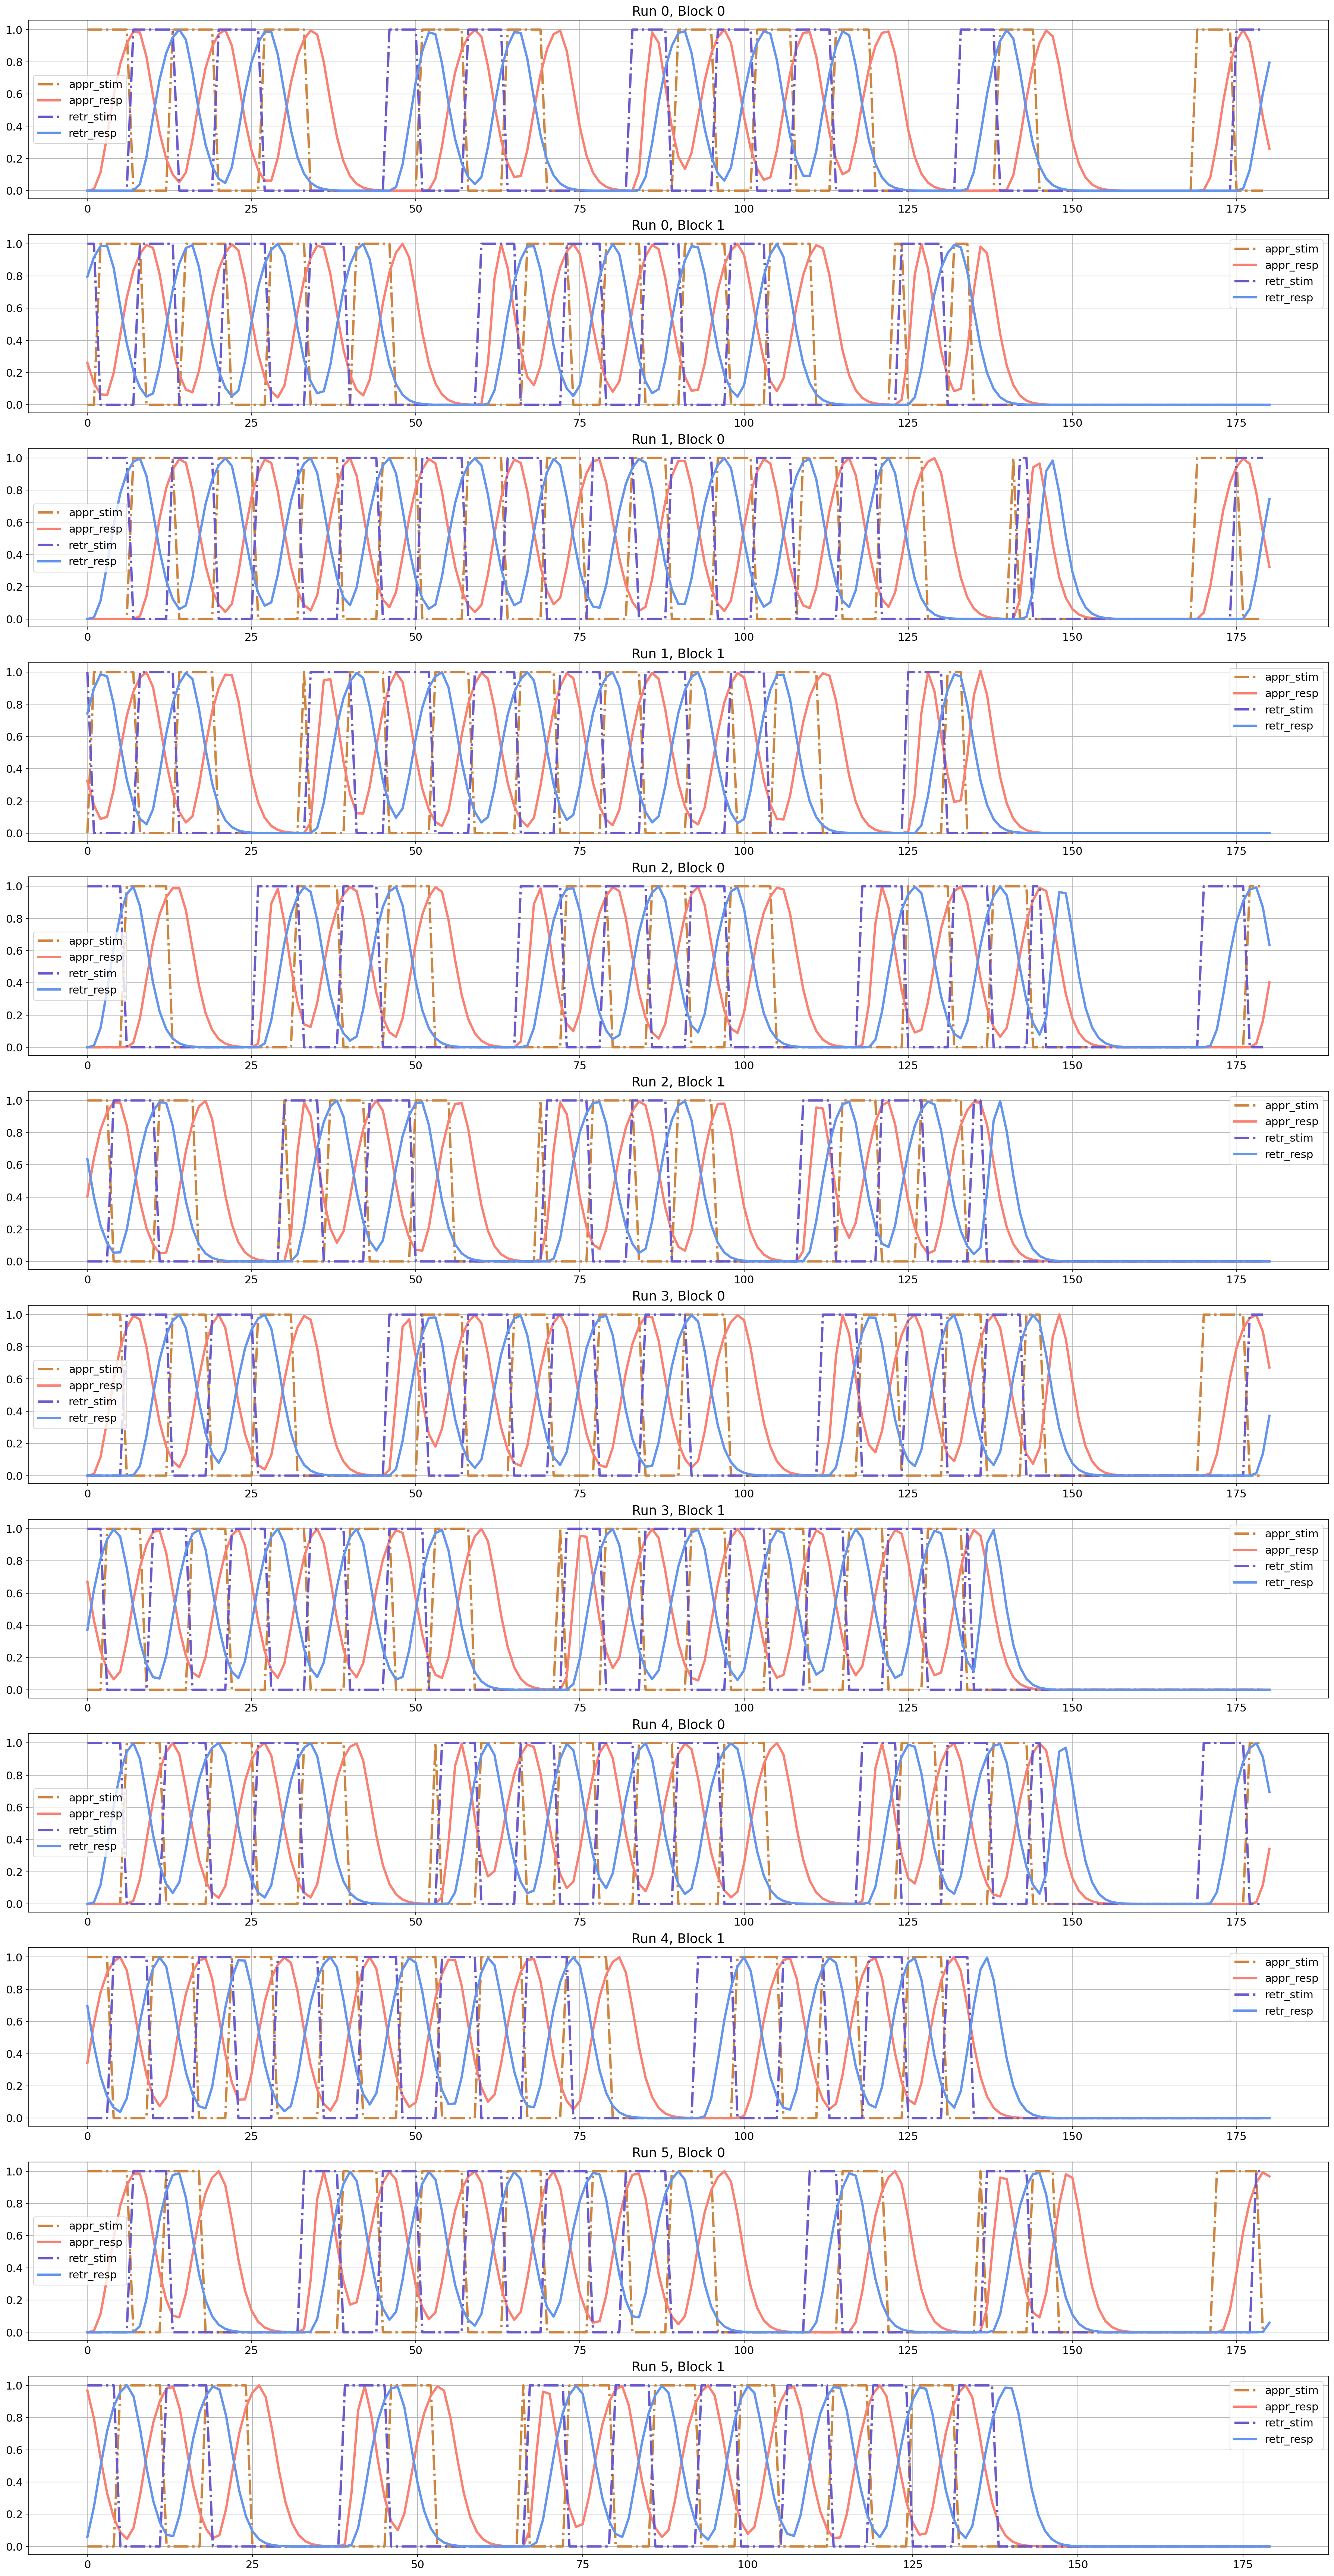

In [6]:
nrows, ncols = num_blocks, 1
figsize = (30*ncols, 5*nrows)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=figsize, 
    sharex=False, 
    sharey=True, 
    dpi=150)
for idx_block in np.arange(num_blocks):
    ax = axs[idx_block]
    ax.set_title(f"Run {(idx_block)//2}, Block {idx_block%2}")
    
    # appr regressor
    ax.plot(appr_stims[idx_block], color='peru', linestyle='-.', linewidth=3, label='appr_stim')
    
    # appr response    
    ax.plot(appr_regs[idx_block], color='salmon', linestyle='-', linewidth=3, label='appr_resp')

    # retr regressor
    ax.plot(retr_stims[idx_block], color='slateblue', linestyle='-.', linewidth=3, label='retr_stim')
    
    # retr response    
    ax.plot(retr_regs[idx_block], color='cornflowerblue', linestyle='-', linewidth=3, label='retr_resp')

    ax.legend()
    ax.grid(True)

**OBSERVATION**
This plot shows that the (canonical) fMRI response is peaks at around 8.75TRs. And the information about the stimulus is present from around 5( or 6)TRs. So we should take segments of the fMRI signal shifted by 5(6)TRs from the onset of stimulus. 


### appr, retr stimuli and combined stimulus 

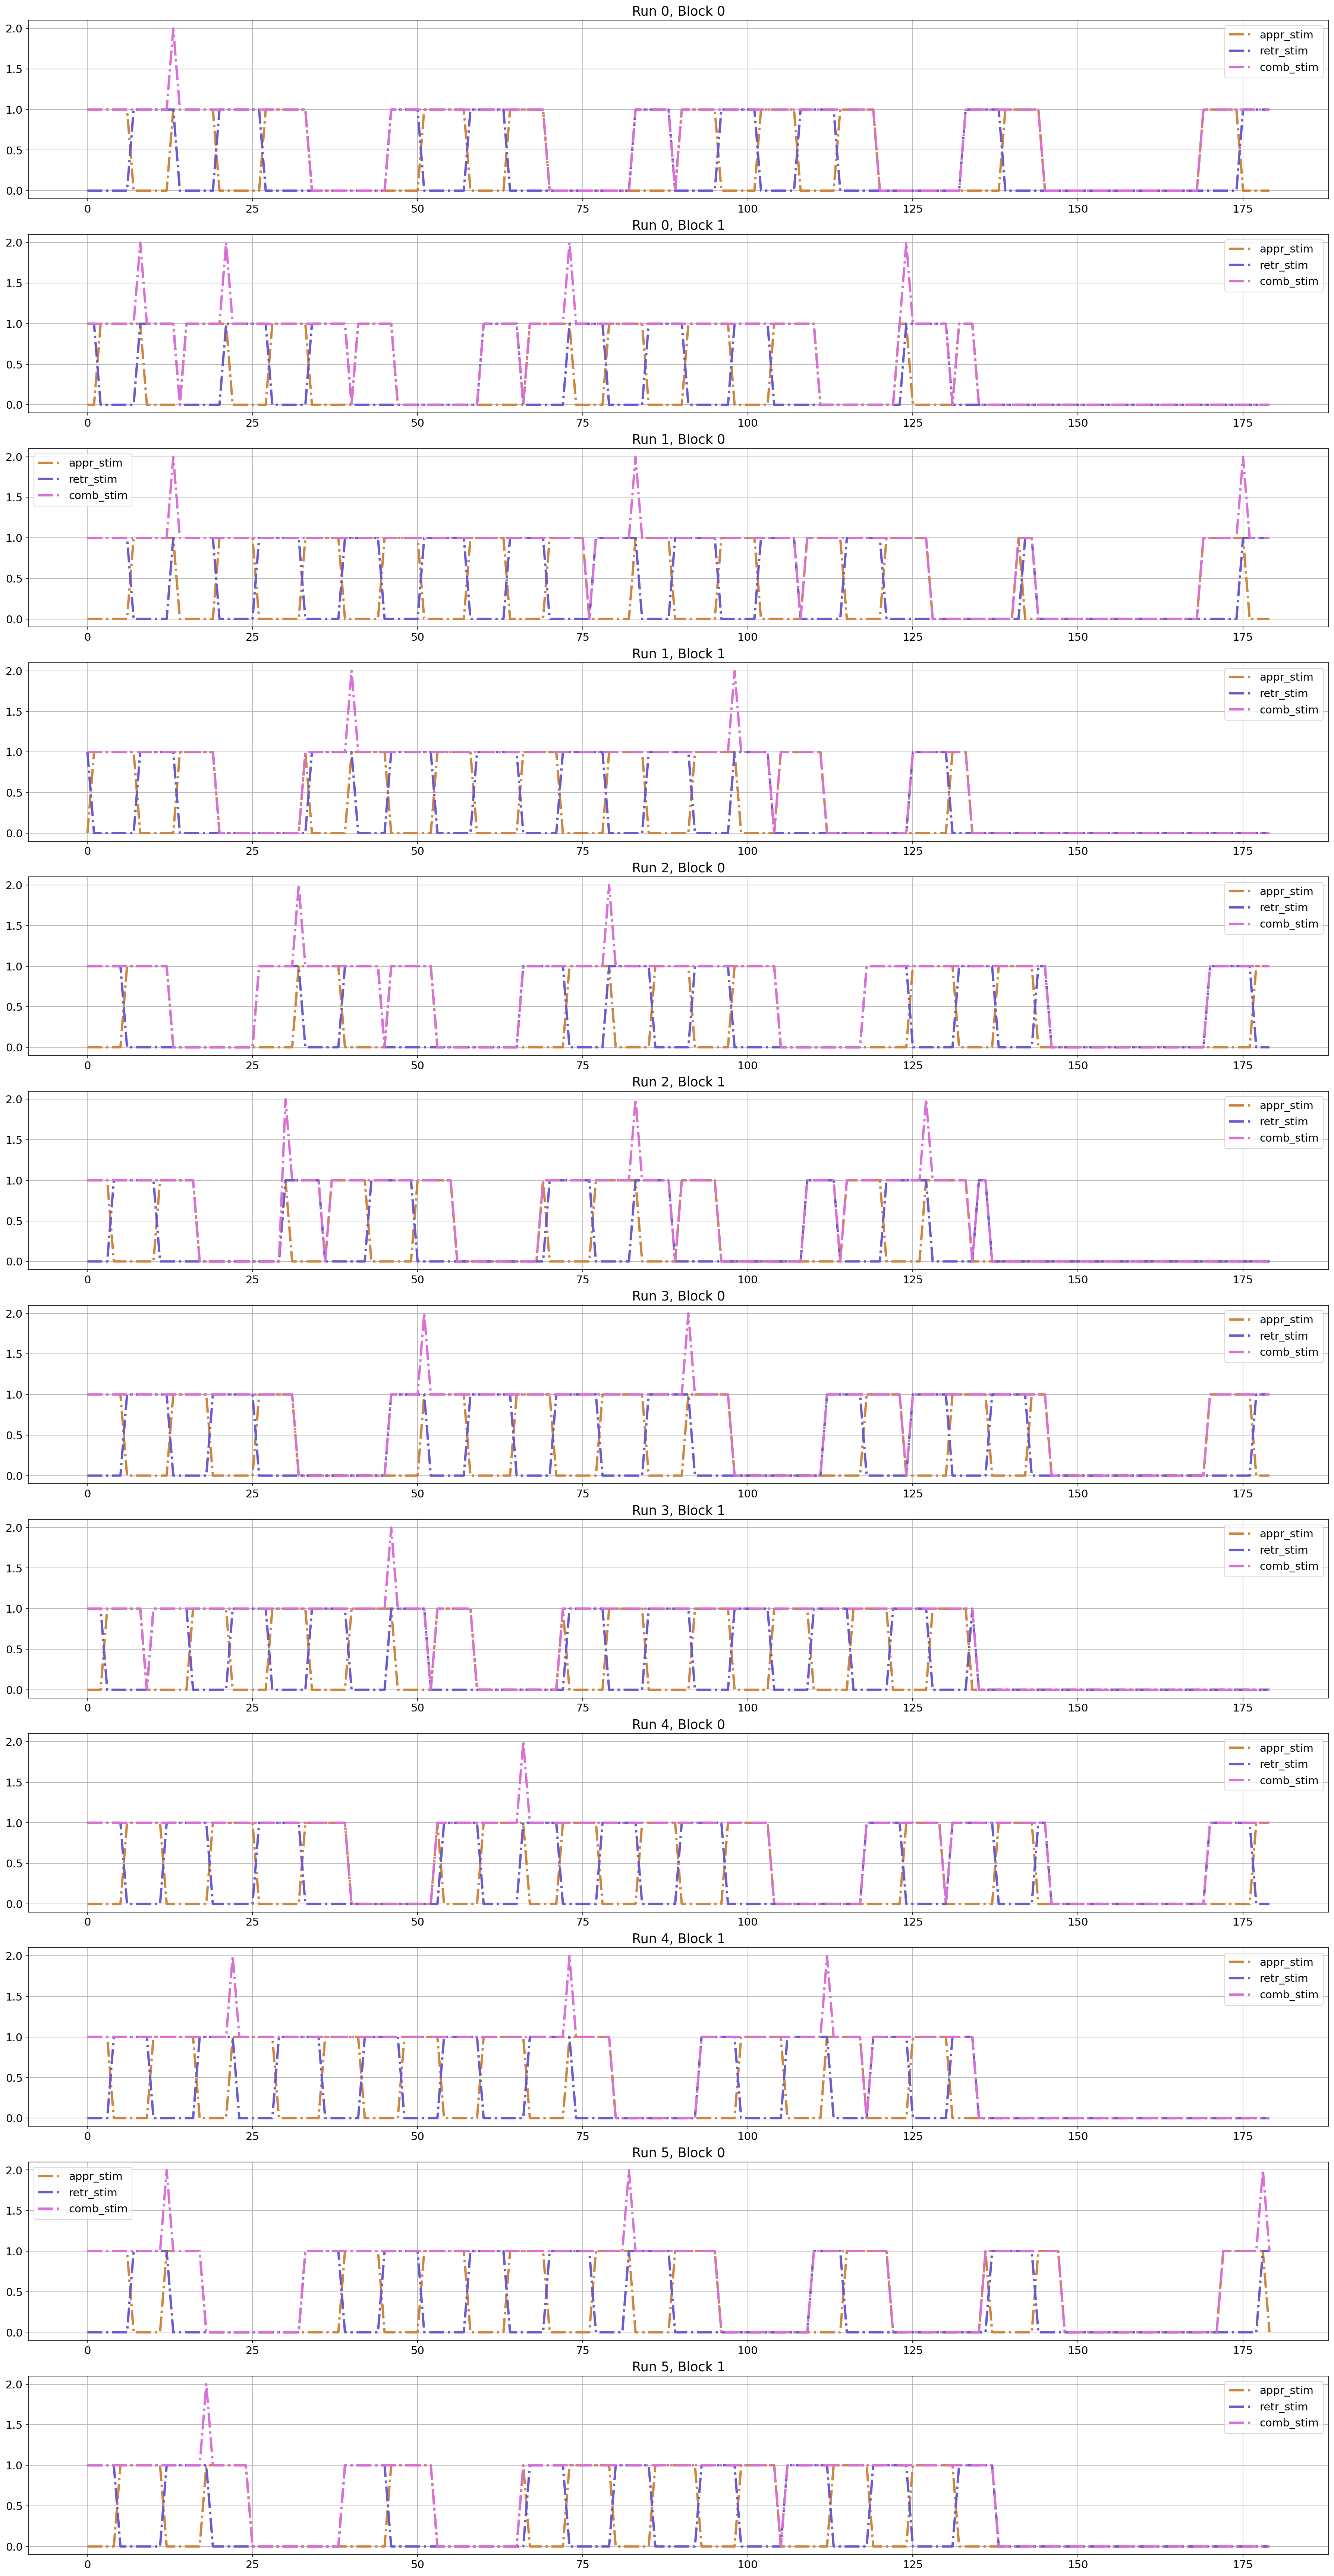

In [7]:
nrows, ncols = num_blocks, 1
figsize = (30*ncols, 5*nrows)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=figsize, 
    sharex=False, 
    sharey=True, 
    dpi=150)
for idx_block in np.arange(num_blocks):
    ax = axs[idx_block]
    ax.set_title(f"Run {(idx_block)//2}, Block {idx_block%2}")
    
    # appr regressor
    ax.plot(appr_stims[idx_block], color='peru', linestyle='-.', linewidth=3, label='appr_stim')

    # retr regressor
    ax.plot(retr_stims[idx_block], color='slateblue', linestyle='-.', linewidth=3, label='retr_stim')

    # combined
    ax.plot(appr_stims[idx_block]+retr_stims[idx_block], color='orchid', linestyle='-.', linewidth=3, label='comb_stim')

    ax.legend()
    ax.grid(True)

### appr, retr responses, and combined response